# Idoven Data Scientist challenge

*Anne Krus - October 2022*

In [35]:
import pandas as pd
import numpy as np
import wfdb
import wfdb.processing
import ast
import re
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from biosppy.signals import ecg
from scipy.signal import welch, argrelmax, argrelmin

# setting to see all columns of larger dfs
pd.pandas.set_option('display.max_columns', None)

# hide elementwise comparison deprecation warnings when annotating the QRS complexes
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Preprocessing

I've downloaded the data using the terminal, and I'll use it from the standard path that it got downloaded to, relative to where the bash script was. The downloading itself therefore does not appear in this notebook.

I'll start with the example python code provided with the data:

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'physionet.org/files/ptb-xl/1.0.2/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

Two csv files are called, in the `ptbxl_database.csv` we have 21801 ECG measurements and 43 columns describing their circumstances, patient characteristics, diagnoses, etc. In the column `scp_codes` strings appear such as `"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"` which we evaluate to a dictionary using `ast.literal_eval`. The relative paths to the 100 Hz and 500 Hz files are directly included in the columns `filename_lr` and `filename_hr`. 

Using the waveform database package and these provided file paths this is converted into a three-dimensional array `X`. Its size is `21801` (ECGs) $\times$ `1000` (10 sec times 100 Hz datapoints) $\times$ `12` (leads).

In the second csv file, `scp_statements.csv`, each of the diagnoses codes is accompanied by a list of characteristics. All of the codes that are listed in this file, where the column `diagnostic` is 1, are considered relevant scp codes. For each of the relevant codes of a ECG, the diagnostic superclass, as listed in the second csv file, is added to the information of the ECG database. This additional column contains a list of unique superclasses, so multiple diagnoses belonging to the same superclass will only result in a single superclass in the final dataframe.

From the readme of the data: 
> Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

This is explicitly not the same as (stratified) k-fold cross-validation, as we only want to use fold 9 for validation, and not iterate over 9 models where each of the folds 1-9 is used for validation.


In [3]:
# Y.head(2)
# agg_df.head(2)
# X.shape

In [4]:
Y.astype({
    'patient_id': 'int32', 'age': 'int32', 
    'sex': 'category', 'nurse': 'category', 'site': 'category', 'device': 'category',
    'recording_date': 'datetime64'}).dtypes

patient_id                               int32
age                                      int32
sex                                   category
height                                 float64
weight                                 float64
nurse                                 category
site                                  category
device                                category
recording_date                  datetime64[ns]
report                                  object
scp_codes                               object
heart_axis                              object
infarction_stadium1                     object
infarction_stadium2                     object
validated_by                           float64
second_opinion                            bool
initial_autogenerated_report              bool
validated_by_human                        bool
baseline_drift                          object
static_noise                            object
burst_noise                             object
electrodes_pr

In [5]:
Y.r_peaks = Y.r_peaks.apply(lambda x: ast.literal_eval('['+re.sub(' +', ', ', str(x)[1:-1].strip())+']'))

I casted the columns to their corresponding data types, and manipulated the list in `r_peaks` such that it can handle one or more spaces between peaks locations and gets converted to a list in the dataframe, similar to the `scp_codes` dictionaries.

Upon examining the list of superclasses as produced by the original example script, I noted that 405 rows produced an empty list. In order to decide what to do with this 1.85% of the data I'll look at their `scp_codes` and see whether they are valid entries: 

In [6]:
Y['diagnostic_superclass'].value_counts()

[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[MI, CD]               1300
[HYP, STTC]             781
[MI, STTC]              600
[HYP]                   535
[CD, STTC]              471
[NORM, CD]              407
[]                      405
[MI, STTC, HYP]         358
[HYP, CD]               300
[MI, CD, STTC]          223
[HYP, CD, STTC]         211
[MI, HYP]               179
[MI, CD, STTC, HYP]     154
[MI, CD, HYP]           113
[NORM, STTC]             28
[NORM, CD, STTC]          5
[HYP, CD, MI]             4
[HYP, MI]                 4
[NORM, CD, HYP]           2
[NORM, HYP]               2
[HYP, MI, STTC]           2
[HYP, MI, STTC, CD]       1
[STTC, HYP, MI]           1
[NORM, CD, MI, HYP]       1
[STTC, HYP, CD, MI]       1
Name: diagnostic_superclass, dtype: int64

In [7]:
no_superclass = list(set(x for d in Y[Y['diagnostic_superclass'].map(lambda d: len(d)) == 0].scp_codes for x in d.keys()))

other_diagnoses_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
other_diagnoses_df = other_diagnoses_df[other_diagnoses_df.diagnostic != 1]

# if set is empty, then all dictionary keys in rows without a superclass are present in scp.csv:
set(no_superclass).difference(other_diagnoses_df.index)

set()

All rows without a listed superclass correspond to valid entries in the list of SCP statements in the csv file. We can therefore not assume them to be normal, or typos, so I will leave them out of my analysis. I'll check the distribution of these cases over the folds before actually removing them:

In [8]:
Y[Y['diagnostic_superclass'].map(lambda d: len(d)) == 0].strat_fold.value_counts()

8     44
4     44
2     43
6     42
7     41
3     41
10    39
5     39
9     36
1     36
Name: strat_fold, dtype: int64

In [9]:
X.shape

(21801, 1000, 12)

In [10]:
X = X[Y['diagnostic_superclass'].map(lambda d: len(d)) > 0]
Y = Y[Y['diagnostic_superclass'].map(lambda d: len(d)) > 0]
X.shape

(21396, 1000, 12)

Next I'll convert the different superclasses into separate columns:

In [11]:
Y = pd.concat([Y, pd.get_dummies(Y['diagnostic_superclass'].apply(pd.Series).stack()).groupby(level=0).sum()], axis=1)

In [12]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

To remove these cases from the train and test data as defined in the beginning I decided to just derive them again from the updated `Y` df.


---

## Plot entire ECG

I'll try to plot one of the ECG signals before looking at anything ML related.

In [13]:
X[0].T.shape

(12, 1000)

Each of the 21396 signals is comprised of the following 12 leads: (I, II, III, AVL, AVR, AVF, V1, ..., V6). [Source](https://physionet.org/content/ptb-xl/1.0.2/)

According to their own visualisation, however, the order of the AVR and AVL signals are swapped, i.e. (I, II, III, AVR, AVL, AVF, V1, ..., V6). This is something to pay extra attention to when plotting. (AVR should peak down, AVL should peak up, and AVF should have less peaks than the other two, for `ecg_id = 1` in the [visualisation tool](https://physionet.org/lightwave/?db=ptb-xl/1.0.2))

Since some records have been removed from both X and Y as well, I checked the plotted results of `ecg_id`s 1, 5, 19, and 21. IDs 17, 18, and 20 were removed, so this allows to check for consistency with the online visualisation both in terms of visualising the correct data for each ecg_id, as well as confirming the order of AVR and AVL.

The function for plotting the ECG grew as I progressed with this notebook. I noticed I needed to check for `leads` input validity and determine the row in which the requested `ecg_id` was located in multiple functions, so I put both functionalities in seperate auxiliary functions.

In [14]:
# auxiliary functions needed for multiple plotting functions

def check_leads_validity(leads):
    allowed_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    if leads == 'all':
        leads = allowed_leads
    elif isinstance(leads, str):
        leads = [leads]

    if not set(leads) <= set(allowed_leads):
        raise ValueError(f'leads should be a subset of:\n{allowed_leads}')
    
    return leads, [allowed_leads.index(lead) for lead in leads]

def get_xrow_of_ecg_id(ecg_id, Y):
    id_dict = {k:v for k, v in zip(Y.index, Y.reset_index().index)}
    try:
        return id_dict[ecg_id]
    except:
        raise ValueError(f'ecg_id {ecg_id} not available for plotting')

In [31]:
def plot_ecg(ecg_id, X, Y, fs=100, leads='all', show_rpeaks=False, y_spacing=2, xrange=[0, 10], figwidth=None, figheight=None, figout=False):
    """
    Plot ECG leads as found in https://physionet.org/content/ptb-xl/1.0.2/, using X and Y as produced by `example_physionet.py`.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        leads : str, list, optional
            string of lead name or 'all' for all 12 leads. Accepts a list of multiple leads in custom order. Default 'all'.
        show_rpeaks : bool, optional
            add markers on the indices listed in the csv file.
        y-spacing : int, float, optional
            how much the y-axis should be stretched to accomodate for the signals to avoid overlap, default 2 mV.
        xrange : list, optional
            limits of x axis in sec, passed as a list. Default [0, 10].
        figwidth : int, float, optional
            figure width in pixels, default None (=automatic scaling).
        figheight : int, float, optional
            figure height in pixels, default None (=automatic scaling).

    Returns
    -------
        plotly.graph_object
            An interactive plotly figure.
    """

    # TODO: (nice-to-have) add recording_date and average bpm in upper right corner, outside graph
    
    leads, lead_idx = check_leads_validity(leads)
    xrow = get_xrow_of_ecg_id(ecg_id, Y)

    time = np.arange(X[xrow].T[0].size) / fs
    data = pd.DataFrame(np.column_stack((time, X[xrow][:,lead_idx])), columns = ['time'] + leads)

    fig = go.Figure()
    for n, lead in enumerate(leads):
        fig.add_scatter(x=data.time, y=data[lead] - n*y_spacing, text=data[lead].map('{:.3f}'.format), name=lead, hoverinfo='x+text+name',showlegend=False)
        if show_rpeaks:
            fig.add_scatter(x=data.time.iloc[Y['r_peaks'].iloc[xrow]], y=data[lead].iloc[Y['r_peaks'].iloc[xrow]] - n*y_spacing, mode='markers', 
                marker={'color':'red','symbol':'0'}, hoverinfo='skip',showlegend=False)

    fig.update_traces(line=dict(color="black", width=1), hovertemplate=None)


    fig.update_layout(
        width=figwidth,
        height=figheight,
        title=f'ECG_id: {ecg_id}, Patient_id: {int(Y.patient_id.loc[ecg_id])}',
        hovermode="x",
        xaxis_title='Time in s',
        yaxis_title='ECG in mV')
    fig.update_xaxes(
        tickvals=np.linspace(0,10,51),
        showticklabels=False,
        range=xrange, 
        showgrid=True, 
        gridwidth=.5, 
        gridcolor='Gray', 
        minor=dict(
            tickvals=np.linspace(0,10,251), 
            showgrid=True, 
            gridwidth=.2, 
            gridcolor='Lightgray'))
    fig.update_yaxes(
        tickvals=np.linspace(0,-len(leads)*y_spacing,len(leads)+1),
        ticktext=leads, 
        minor=dict(
            tickvals=np.linspace(1.5,-len(leads)*y_spacing,int(len(leads)*y_spacing*2+4)), 
            showgrid=True, 
            gridwidth=.5, 
            gridcolor='Gray'))
    
    if figout:
        return fig
    else:
        fig.show()

plot_ecg(ecg_id=350, X=X, Y=Y, fs=sampling_rate, leads='all', show_rpeaks=False, y_spacing=2, xrange=[0, 10], figwidth=None, figheight=900)


---

## Extract average heart rate

In the publishers [article](https://www.nature.com/articles/s41597-020-0495-6) they recommend using the [BioSPPy](https://github.com/PIA-Group/BioSPPy) package to analyse the signals. I'll start there to extract the average and total heart beat in the signals and identify the QRS peak.

In [16]:
for ecg_id in range(1,10):

    id_dict = {k:v for k, v in zip(Y.index, Y.reset_index().index)}
    xrow = id_dict[ecg_id]

    out = ecg.ecg(signal=X[xrow][:,0], sampling_rate=sampling_rate, show=False, interactive=False)
    rpeaks = out[2]
    # print(rpeaks)
    # print(Y.loc[ecg_id]['r_peaks'])

    # print(set(rpeaks).symmetric_difference(set(Y.iloc[xrow]['r_peaks'])))

After investigating the `r_peaks` provided in the original data to the r_peaks as identified here (uncomment lines 8 to 11 above if interested), this algorithm often misses the first peak, and they do often differ bij 1 index in the exact location of the R-peak. I therefore assume that the index locations provided in the column `r_peaks` in the csv data are preferred over the automatically calculated locations.

I'll extract the heart rate in beats per minute (bpm) based on the peak locations:

In [17]:
def heart_rate(rpeaks, sampling_rate=100):
    """Calculate heart rate in bpm from an array of R-peak indices at a certain sampling rate in Hz.

    Parameters
    ----------
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        sampling frequency (Hz), default is 100.

    Returns
    -------
    avg_heart_rate : array
        averaged heart rates (bpm) between subsequent peaks.
    std_heart_rate : array
        standard deviation of heart rate (bpm) between subsequent peaks.
    """
    
    if len(rpeaks) < 2:
        raise ValueError("Not enough R-peaks to compute heart rate.")

    bpms = sampling_rate * (60.0 / np.diff(rpeaks))

    return bpms.mean(), bpms.std()

heart_rate(Y.iloc[0]['r_peaks'], sampling_rate=sampling_rate)

(63.91287464131966, 0.9815598485340523)

In [18]:
Y['avg_bpm'], Y['std_bpm'] = zip(*Y['r_peaks'].apply(heart_rate, sampling_rate=sampling_rate))

I noticed that in the code of the BioSPPy heart rate function, which is built into their [ecg](https://biosppy.readthedocs.io/en/latest/biosppy.signals.html?highlight=tools#biosppy.signals.ecg.ecg) function, that they exclude bpms below 40 and above 200. Let's see how many of these cases we actually have in our database:

In [19]:
print(len(Y[Y['avg_bpm'] < 40]))
print(len(Y[Y['avg_bpm'] > 200]))

27
0


I'll visually check if there is something wrong with the identification of the R-peaks as listed in the csv in the first case where the average bpm was found to be <40:

In [20]:
plot_ecg(ecg_id=int(Y[Y['avg_bpm'] < 40].index.tolist()[0]), X=X, Y=Y, y_spacing=2, show_rpeaks=True, figheight=800)

The R-peaks don't seem to have been wrongly identified, or missing any peaks. Technically, in rest, an adult would ideally have a heart rate of 60-100 bpm. Lower heart rates indicate bradycardia and higher heart rates indicate tachycardia. Since I one the one hand don't know or choose not to investigate the circumstances of the ECGs in this list, and on the other hand am equally interested in normal ECGs as in abnormal ones, I have decided to not include the limits proposed in the BioSPPy package and leave all ECGs in. I've visualised the average heart rates per diagnostic superclass, alongside the "normal" limits in gray in the graph below:

In [21]:
superclasses = agg_df['diagnostic_class'].unique().tolist()

fig = make_subplots(rows=1, cols=len(superclasses), shared_yaxes=True)
for i, column in enumerate(superclasses):
    fig.add_trace(go.Box(y=Y[Y[column]==1]['avg_bpm'], #boxpoints='all', jitter=0.3, 
    name=column),row=1, col=i+1)
    fig.add_hline(y=60, line_width=2, line_color="lightgray", name='Normal limits', row=1, col=i+1)
    fig.add_hline(y=100, line_width=2, line_color="lightgray", row=1, col=i+1)
    fig.add_hline(y=40, line_width=2, line_color="lightgray", line_dash='dash', name='Physiological limits', row=1, col=i+1)
    fig.add_hline(y=200, line_width=2, line_color="lightgray", line_dash='dash', row=1, col=i+1)

fig.update_layout(title='Heart rates')
fig.show()


---

## Extract heart beats

In the BioSPPy code I've found a [`extract_heartbeats`](https://biosppy.readthedocs.io/en/latest/_modules/biosppy/signals/ecg.html#extract_heartbeats) function that seems to extract the heart beats. I prefer, however, to use it as a starting point for my own code, rather than a finished product, as I on the one hand want to understand what their code does, and on the other hand I am not too convinced by the package from the looks of its documentation. 

I will *extract* the heart beats in one function, and *plot* them in another function:

In [22]:
def get_templates(ecg_id, X, Y, fs=100, leads='all', window=[-0.2,0.4]):
    """
    Take the R-peaks listed in dataframe Y, and make "snapshots" of the ECG time signals around each peak. 
    Default time window is 0.2 sec before to 0.4 seconds after each peak. Does not discard incomplete windows.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        leads : str, list, optional
            string of lead name or 'all' for all 12 leads. Accepts a list of multiple leads in custom order. Default 'all'.
        window : list, optional
            list of two float numbers, stating the amount of seconds before and after an R-peak that are of interest. Default [-0.2,0.4].
    
    """
    leads, lead_idx = check_leads_validity(leads)
    xrow = get_xrow_of_ecg_id(ecg_id, Y)
        
    windowlength = int((window[1] - window[0])*fs)
    time_templates = np.nan*np.ones([len(leads),len(Y['r_peaks'].loc[ecg_id]),windowlength])
    templates      = np.nan*np.ones([len(leads),len(Y['r_peaks'].loc[ecg_id]),windowlength])
    for i, lead in enumerate(lead_idx):
        signal = X[xrow][:,lead]
        if  windowlength > len(signal):
            time = range(len(signal)) - Y['r_peaks'].loc[ecg_id][0]
            return time, signal

        else:
            for j, r in enumerate(Y['r_peaks'].loc[ecg_id]):
                a = r + int(window[0]*fs)
                b = r + int(window[1]*fs)
                if a < 0:
                    templates[i][j][-len(signal[0:b]):] = signal[0:b]
                elif b > len(signal):
                    templates[i][j][:len(signal[a:])] = signal[a:]
                else:
                    templates[i][j][:] = signal[a:b]
        
    return templates

window = [-0.2, 0.4]
ecg_id = 3
A = get_templates(ecg_id, X, Y, sampling_rate, 'all', window)

In [23]:
def plot_avg_templates(ecg_id, X, Y, fs=100, leads='all', window=[-0.2,0.4], figwidth=None, figheight=None):
    """
    Plot heartbeats in ECG leads on top of one another. Based on https://physionet.org/content/ptb-xl/1.0.2/, using X and Y as produced by `example_physionet.py`.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        leads : str, list, optional
            string of lead name or 'all' for all 12 leads. Accepts a list of multiple leads in custom order. Default 'all'.
        window : list, optional
            list of two float numbers, stating the amount of seconds before and after an R-peak that are of interest. Default [-0.2,0.4].
        figwidth : int, float, optional
            figure width in pixels, default None (=automatic scaling).
        figheight : int, float, optional
            figure height in pixels, default None (=automatic scaling).

    Returns
    -------
        plotly.graph_object
            An interactive plotly figure.
    """

    leads, lead_idx = check_leads_validity(leads)
    xrow = get_xrow_of_ecg_id(ecg_id, Y)
    
    timevalues = list(np.linspace(window[0],window[1],int((window[1] - window[0])*fs)).round(decimals=2))

    fig = make_subplots(rows=1, cols=len(leads), shared_yaxes=True, 
        subplot_titles=(leads),
        x_title='Time in sec',
        y_title='ECG in mV')
    
    
    kwargs = dict(showlegend=True)
    
    for i, lead in enumerate(lead_idx):
        templates = get_templates(ecg_id, X, Y, fs=fs, leads=leads, window=window)
        discrete_colors = px.colors.sample_colorscale('Greys', np.linspace(0.1,1,len(Y['r_peaks'].loc[ecg_id])))
        for j, template in enumerate(templates[i]):
            fig.add_scatter(x=timevalues,y=template, 
                line_color=discrete_colors[j], line_width=0.5, 
                hoverinfo='none', hovertemplate=None, name=f'R-peak {j+1}', **kwargs,
                row=1, col=i+1)
        fig.add_scatter(x=timevalues,y=np.nanmean(templates[i],axis=0), 
            line_color='darkred', line_width=1.5, 
            text=np.nanmean(templates[i],axis=0).round(decimals=3),
            hoverinfo='text', name=f'Avg heartbeat', **kwargs, 
            row=1, col=i+1)
        kwargs = dict(showlegend=False)

    fig.update_layout(
        width=figwidth,
        height=figheight,
        hovermode="x",
        title=f'ECG_id: {ecg_id}, Patient_id: {int(Y.patient_id.loc[ecg_id])}')
    fig.show()

ecg_id=4
plot_avg_templates(ecg_id, X, Y, fs=100, leads='all', window=[-0.2,0.4], figwidth=None, figheight=600)

As a reference, I've also looked at the templates produced by the BioSPPy package. I've noticed they apply a bandpass filter of 3 to 45 Hz to their signal before processing or plotting it in the `ecg` function, so in their `extract_heartbeats` function it isn't directly included. I'll plot both their results in the same style as above for comparison:

In [24]:
def plot_avg_templates2(ecg_id, X, Y, fs=100, leads='all', func = 'ecg', figwidth=None, figheight=None):
    """
    Plot ECG leads as found in https://physionet.org/content/ptb-xl/1.0.2/, using X and Y as produced by `example_physionet.py`.
    Uses BioSPPy package.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        leads : str, list, optional
            string of lead name or 'all' for all 12 leads. Accepts a list of multiple leads in custom order. Default 'all'.
        func : string
            function to use from BioSPPy package, can be 'ecg' or 'extract_heartbeats'. Default 'ecg'.
        figwidth : int, float, optional
            figure width in pixels, default None (=automatic scaling).
        figheight : int, float, optional
            figure height in pixels, default None (=automatic scaling).

    Returns
    -------
        plotly.graph_object
            An interactive plotly figure.
    """

    allowed_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    if leads == 'all':
        leads = allowed_leads
    elif isinstance(leads, str):
        leads = [leads]

    if not set(leads) <= set(allowed_leads):
        raise ValueError(f'leads should be a subset of:\n{allowed_leads}')

    lead_idx = [allowed_leads.index(lead) for lead in leads]

    id_dict = {k:v for k, v in zip(Y.index, Y.reset_index().index)}
    try:
        xrow = id_dict[ecg_id]
    except:
        raise ValueError(f'ecg_id {ecg_id} not available for plotting')

    fig = make_subplots(rows=1, cols=len(leads), shared_yaxes=True, 
        subplot_titles=(leads),
        x_title='Time in sec',
        y_title='ECG in mV')

    for i in range(0,len(leads)):
        if func == 'ecg':
            out = ecg.ecg(signal=X[xrow][:,i], sampling_rate=fs, show=False, interactive=False)
            for template in out['templates']:
                fig.add_scatter(x=out['templates_ts'],y=template, 
                    line_color="gray", line_width=0.5, 
                    hoverinfo='x', hovertemplate=None, showlegend=False,
                    row=1, col=i+1) 
            fig.add_scatter(x=out['templates_ts'],y=template, 
                line_color='black', line_width=0.75, 
                text=np.average(out["templates"],axis=0).round(decimals=3),
                hoverinfo='x+text', showlegend=False, 
                row=1, col=i+1)
        elif func == 'extract_heartbeats':
            out, _ = ecg.extract_heartbeats(signal=X[xrow][:,i], rpeaks=Y['r_peaks'].iloc[xrow], sampling_rate=fs, before=0.2, after=0.4)
            ts_tmpl = np.linspace(-0.2, 0.4, out.shape[1], endpoint=False)
            for template in out:
                fig.add_scatter(x=ts_tmpl,y=template, 
                    line_color="gray", line_width=0.5, 
                    hoverinfo='x', hovertemplate=None, showlegend=False,
                    row=1, col=i+1) 
            ## Average not calculated for this comparison, found too cumpersome here. Nice-to-have.
            # fig.add_scatter(x=ts_tmpl,y=template, 
            #     line_color='black', line_width=0.75, 
            #     text=np.average(out,axis=0).round(decimals=3),
            #     hoverinfo='x+text', showlegend=False, 
            #     row=1, col=i+1)
        else:
            raise ValueError(f"Keyword argument func ({func}) not in ['ecg', 'extract_heartbeats'].")

    fig.update_layout(
        width=figwidth,
        height=figheight,
        hovermode="x",
        title=f'ECG_id: {ecg_id}, Patient_id: {int(Y.patient_id.loc[ecg_id])}')
    fig.show()
    return out

ecg_id=4
plot_avg_templates2(ecg_id, X, Y, fs=100, leads='all', func='ecg',figwidth=None, figheight=600)
out = plot_avg_templates2(ecg_id, X, Y, fs=100, leads='all', func='extract_heartbeats',figwidth=None, figheight=600)

The difference between the filtered and unfiltered signal is very obvious for example in `ecg_id = 4`, especially in leads II, III, and AVF. As I lack the medical background to interpret the significance of a loq frequency fluctuation on top of an ECG signal, I prefer to not apply a bandpass or high-pass filter and leave this information in. To check the frequencies we're talking about I'll convert the signal to its power spectrum, and visualize their frequency domains.

In [25]:
def plot_freqs_per_lead(ecg_id, X, Y, fs=100, leads='all', freqlims = None, freqres = None, figwidth=None, figheight=None):
    """
    Plot power spectrum in different ECG leads. Based on https://physionet.org/content/ptb-xl/1.0.2/, using X and Y as produced by `example_physionet.py`.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        leads : str, list, optional
            string of lead name or 'all' for all 12 leads. Accepts a list of multiple leads in custom order. Default 'all'.
        freqlims : list, optional
            list of two float numbers, stating the lowest and highest frequency of interest, in Hz. Default None.
        freqres : float, optional
            desired frequency resolution of the power spectrum. Default None uses a window of 256, yielding a resolution of fs/256 Hz.
        figwidth : int, float, optional
            figure width in pixels, default None (=automatic scaling).
        figheight : int, float, optional
            figure height in pixels, default None (=automatic scaling).

    Returns
    -------
        plotly.graph_object
            An interactive plotly figure.
    """

    leads, lead_idx = check_leads_validity(leads)
    xrow = get_xrow_of_ecg_id(ecg_id, Y)

    if freqres:
        samples_N = len(X[xrow][:,lead_idx[0]])
        nperseg = sampling_rate / freqres
        if nperseg > samples_N:
            nperseg = samples_N
            raise ValueError(f'Warning: freqres lower than minimum. Input a longer signal at same frequency to improve the resolution. Freqres set to minimum of {sampling_rate / samples_N}.')
    else:
        nperseg = 256
    
    fig = make_subplots(rows=1, cols=len(leads), shared_yaxes=True, 
        subplot_titles=(leads),
        x_title='Frequency in Hz',
        y_title='Power spectrum of the ECG in mV <sup>2</sup>')
    
    flen, _ = welch(X[xrow][:,lead_idx[0]], fs=sampling_rate, nperseg=nperseg, scaling="spectrum")
    f = np.nan*np.ones([len(leads),len(flen)])
    Pxx = np.nan*np.ones([len(leads),len(flen)])

    for i, lead in enumerate(lead_idx):
        signal = X[xrow][:,lead]
        f[i], Pxx[i] = welch(signal, fs=sampling_rate, nperseg=nperseg, scaling="spectrum")
        fig.add_scatter(x=f[i],y=Pxx[i], line_width=0.5, line={'color':'black'},
            hoverinfo='x+y', hovertemplate=None, name=lead, showlegend=False,
            row=1, col=i+1)
            
    if freqlims:
        fig.update_xaxes(range=freqlims)
        freq_idx = [[freq >= freqlims[0] for freq in f[0]].index(True), -[freq < freqlims[1] for freq in f[0][::-1]].index(True)]
        fig.update_yaxes(range=np.log10([np.amin(Pxx[:,freq_idx[0]:freq_idx[1]]),np.amax(Pxx[:,freq_idx[0]:freq_idx[1]])]))
    else:
        fig.update_xaxes(range=f[[0, -1]])
        
    fig.update_yaxes(type='log')
    
    fig.update_layout(
        width=figwidth,
        height=figheight,
        hovermode="x",
        xaxis=dict(hoverformat='.3f'), # not working, don't know why
        yaxis=dict(hoverformat='.3f'), # not working, don't know why
        title=f'ECG_id: {ecg_id}, Patient_id: {int(Y.patient_id.loc[ecg_id])}')

    fig.show()

ecg_id=4
plot_freqs_per_lead(ecg_id, X, Y, fs=100, leads='all', freqlims=[0, 10], figwidth=None, figheight=600)

We obtain peaks at the first frequency point 0.39 Hz in each of the "suspicious" leads I, II, and AVF, while also showing comparably high values in leads V2 V4 and V5. We would need to increase the frequency resolution to further investigate the exact behaviour we are dealing with.

The frequency function allows a zoomed in window in `x`, while calling the function, such that the `y` axis gets scaled accordingly. The windowing function used when computing the power spectrum is automatically set to 256 samples. By increasing the window size we reduce the amount of windows in the signal while increasing the amount of overlap between the windows. A larger window will, however, translate to a higher resolution in frequency domain. By considering the entire time-signal available (10sec, N=1000 samples) our maximal achievable frequency resolution at fs = 100 Hz is **fs/N = 0.1 Hz**. We would then be evaluating one single window.

In [26]:
ecg_id=4
plot_freqs_per_lead(ecg_id, X, Y, fs=100, leads='all', freqlims=[0, 5], freqres = 0.1, figwidth=None, figheight=600)

When considering the entire signal as a single window, the difference between the highest amplitudes in leads II, III, and AVF *does* show up when comparing to other leads. Let's look at these specific signals and the identified base frequency at 0.1 Hz to see if this makes any sense.

In [27]:
ecg_id = 4
plot_avg_templates(ecg_id=ecg_id, X=X, Y=Y)
plot_ecg(ecg_id, X, Y, leads = ['II','III','AVF'], figheight=900)

freq_Hz = 0.1
phase_rad = -0.65 * np.pi

x = np.linspace(0,10,10*sampling_rate)
y = np.sin(2 * np.pi * freq_Hz * x + phase_rad)

fig = go.Figure()
fig.add_scatter(x=x, y=y, showlegend=False)
fig.update_layout(
    title="Sine wave",
    xaxis_title="Time in sec",
    yaxis_title="Amplitude")
fig.show()

Visually, the waves line up, so this identified 0.1 Hz fluctuation is indeed present in these leads and further investigation would be necessary to decide whether or not this is relevant or due to the measurement equipment. For comparison, in `ecg_id = 3`, the high amplitude base frequency is at 0.2 Hz, i.s.o. 0.1 Hz, which visually looks as follows:

In [32]:
ecg_id = 3
plot_freqs_per_lead(ecg_id, X, Y, fs=100, leads='all', freqlims=[0, 3], freqres = 0.1, figwidth=None, figheight=600)
plot_ecg(ecg_id, X, Y, leads = ['II','III','AVF'], y_spacing = 0.5, figheight=700)

freq_Hz = 0.2
phase_rad = -0.6 * np.pi

x = np.linspace(0,10,10*sampling_rate)
y = np.sin(2 * np.pi * freq_Hz * x + phase_rad)

fig = go.Figure()
fig.add_scatter(x=x, y=y, showlegend=False)
fig.update_layout(
    title="Sine wave",
    xaxis_title="Time in sec",
    yaxis_title="Amplitude",
    height=300)
fig.show()


---

## Identify the QRS complex

For the QRS complex I first had to look up the definition: I'll assume that each of the R-peak locations as listed in the csv is preceded (Q) and followed (S) by dips below the baseline, with some flat baseline around those dips, and then smaller bumps (P and T) to the wider extent of that. I therefore interpret this question of identifying the QRS complex as identifying the beginning of the Q dip and the end of the S dip, for each heart beat, i.e. for each listed R-peak. 
A classic way to go about this seems to be Pan-Tompkins algorithm. Furthermore, the WFDB package I had loaded anyway provides a QRS detector similar to but not equal to Pan-Tompkins. I'll try both.

#### WFDB Package

Number of peaks listed in csv: 13
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


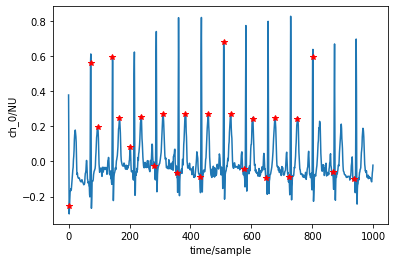

In [36]:
ecg_id = 46
xrow = get_xrow_of_ecg_id(ecg_id, Y)
leads, lead_idx = check_leads_validity(['I'])

print('Number of peaks listed in csv:',len(Y['r_peaks'].iloc[xrow]))
signal = np.ndarray.flatten(X[xrow][:, lead_idx])
xqrs = wfdb.processing.XQRS(signal, sampling_rate, conf=None)
xqrs.detect()
plot_ecg(ecg_id, X, Y, leads = leads, show_rpeaks=True)
wfdb.plot_items(signal=signal, ann_samp=[xqrs.qrs_inds])
plot_avg_templates(ecg_id, X, Y, leads=leads, figwidth = 600)

Not too impressed with the wfdb package, as it says it identifies 8 beats (out of 13), but then marks 24 asterisks in the signal, which I'm not too sure on what they mean. I cannot fully understand their documentation, unfortunately.

#### Pan-Tompkins

I've found an implemented Python code of this algorithm on Github: [link](https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection/blob/5a76ed7b82b1bca8a40f58dc4125ab81cbfa95f1/Pan_Tompkins.ipynb).

In [37]:
class Pan_Tompkins_QRS(): # From https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed 
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds. 

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()
	
    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12] 
	
    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal, fs):                          # added fs as argument
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*fs)/8 # replaced annoptation.fs by fs

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result    

  def moving_window_integration(self,signal, fs):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * fs) # changed annotation.fs for fs
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum
    
    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):  
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal,fs):                                # added fs as argument
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned. 
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    global der
    der = self.derivative(bpass.copy(),fs)                  # added fs as argument

    # Squaring Function
    global sqrsig                                           # renamed global sqr to sqrsig
    sqrsig = self.squaring(der.copy())                      # renamed global sqr to sqrsig

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqrsig.copy(),fs) # added fs as argument

    return mwin

In [38]:
ecg_id = 46
xrow = get_xrow_of_ecg_id(ecg_id, Y)
leads, lead_idx = check_leads_validity(['I'])

QRS_detector = Pan_Tompkins_QRS()
signal = np.ndarray.flatten(X[xrow][:,lead_idx])
time = np.linspace(0,len(signal)/sampling_rate,len(signal))
ecg_df = pd.DataFrame(np.column_stack((time, signal)), columns = ['TimeStamp','ecg'])
output_signal = QRS_detector.solve(ecg_df, sampling_rate) # added sampling_rate as argument, to not need `annotation.fs`

To visualize each of the steps of the Pan-Tompkins algorithm I've added the `plot_pan_tompkins_steps` function:

In [39]:
def plot_pan_tompkins_steps(ecg_id, X, Y, fs=100, leads='I', plotnames='all', figwidth=None, figheight=None):
    """
    Plot conversion steps of the Pan-Tompkins algorithm. Data based on https://physionet.org/content/ptb-xl/1.0.2/, using X and Y as produced by `example_physionet.py`. Algorithm based on implementation on https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        leads : str, list, optional
            string of a single lead name. Default 'I'.
        plotnames : list, optional
            list of plot names, or 'all'. Raises error if incorrect, stating the options. Default 'all'.
        figwidth : int, float, optional
            figure width in pixels, default None (=automatic scaling).
        figheight : int, float, optional
            figure height in pixels, default None (=automatic scaling).

    Returns
    -------
        plotly.graph_object
            An interactive plotly figure.
    """

    # TODO: - (nice-to-have) Similar to plot_ecg plot everything in the same plot, with a difference in y, 
    #         while still displaying the original y values, such that the hovermode shows the y values across all plots simultaneously.
    #       - (nice-to-have) Calculate start_idx properly, such that signals line up nicely with time-signal.

    xrow = get_xrow_of_ecg_id(ecg_id, Y)
    leads, lead_idx = check_leads_validity(leads)
    if len(leads) > 1:
        raise ValueError('Do not provide more than one lead name.')

    QRS_detector = Pan_Tompkins_QRS()
    signal = np.ndarray.flatten(X[xrow][:,lead_idx])
    time = np.linspace(0,len(signal)/fs,len(signal))
    ecg = pd.DataFrame(np.column_stack((time, signal)), columns = ['TimeStamp','ecg'])
    output_signal = QRS_detector.solve(ecg, fs)
    
    plotopts = ['Original Signal','Bandpassed Signal','Derivative Signal','Squared Signal','Moving Window Integrated Signal']
    ytitles = ['mV','mV','mV\'','mV\'<sup>2</sup>','d/dt (mV\'<sup>2</sup>)']
    start_idx = 20 # Deduced by trial-and-error, should be calculated from sampling_rate and filter settings
    stop_idx = len(time)
    timeopts = [time, time[:stop_idx-start_idx], time[:stop_idx-start_idx], time[:stop_idx-start_idx], time[:stop_idx-start_idx]]
    yopts = [signal, bpass[start_idx:stop_idx], der[start_idx:stop_idx], sqrsig[start_idx:stop_idx], mwin[start_idx:stop_idx]]

    if plotnames == 'all':
        plot_idx = range(len(plotopts))
        plotnames = plotopts
    else:
        plot_idx = [i for i, plotname in enumerate(plotopts) if plotname in plotnames]
        discarded = [plotname for plotname in plotnames if plotname not in plotopts]
        plotnames = [plotname for plotname in plotnames if plotname in plotopts]
        if len(discarded) > 0:
            raise ValueError("Incorrect plot name option, choose 'all' or one or more from ['Original Signal','Bandpassed Signal','Derivative Signal','Squared Signal','Moving Window Integrated Signal'.")
        print(f'Printing the following plots: {plotnames}')

    fig = make_subplots(rows=len(plot_idx), cols=1, shared_xaxes=True, 
        subplot_titles=(plotnames),vertical_spacing=0.03,
        x_title='Time in s')

    for row, plot_i in enumerate(plot_idx):
        fig.add_scatter(x=timeopts[plot_i],y=yopts[plot_i], line_width=0.5, line={'color':'black'},
            hoverinfo='x+y', hovertemplate=None, name=plotnames[0], showlegend=False,
            row=row+1, col=1)
        fig.update_yaxes(title_text=ytitles[plot_i], row=row+1, col=1)
    
    fig.update_layout(
        width=figwidth,
        height=figheight,
        hovermode="x",
        title=f'ECG_id: {ecg_id}, Patient_id: {int(Y.patient_id.loc[ecg_id])}')

    fig.show()

plot_pan_tompkins_steps(ecg_id, X, Y, fs=100, leads='I', plotnames='all', figwidth=700, figheight=1200)

I interpret the assignment of "identifying the QRS complex" to mean something different than to identify the R-peaks, something that seems to be used interchangeably wherever I look. I've set myself the objective of identifying the beginning and end of the QRS complex and adding a shaded background to the time-plot, or to trace the part of the signal that belongs to a QRS complex with a thicker red line for example.

In [40]:
def get_qrs_time_limits(time, sqrsig, rpeakidx, threshold=20, verbose=False):
    """
    Uses the Pan-Tompkins algorithm and its squared signal in particular. It uses provided R-peak indices, although these should be detectable from this same signal. This signal (and the R-peaks indices) can be calculated e.g. following https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection.

    Parameters
    ---------- 
        time : numpy.ndarray
            time in seconds corresponding to each point in sqrsig.
        sqrsig : numpy.ndarray
            squared values of the derivative bandpassed ECG lead as produced in the Pan-Tompkins algorithm. 
        rpeakidx : list
            list of indices of each of the R-peaks.
        threshold : float, optional
            discard local minima exceeding this threshold in mV'^2. Default 20.
        verbose : bool, optional
            print statements on the updated values, default False.

    Returns
    -------
        numpy.ndarray
            an array that matches the length of rpeakidx, with a list of 2 timestamps in each index, corresponding to the beginning and end of each QRS complex around the R-peaks.
    """
    
    # TODO: - incorporate calculation of 20 index shift at beginning of signal or pass as argument
    #       - Avoid "DeprecationWarning: elementwise comparison failed; this will raise an error in the future." Probably stems from one of the many "==" in the code.

    sqrsigtimes = time[:-20] # 20 inherited from alignment in plot_pan_tompkins_steps()
    sqrsig_new = sqrsig[20:]
    mintimes = sqrsigtimes[argrelmin(sqrsig_new)]

    qrs_tlims = np.nan*np.ones([len(rpeakidx),2])

    for p, rpeak in enumerate(rpeakidx):
        if sqrsigtimes[rpeak] in mintimes:
            mintimes_peak_min= mintimes[mintimes == sqrsigtimes[rpeak]]
        elif sqrsigtimes[rpeak-1] in mintimes:
            mintimes_peak_min= mintimes[mintimes == sqrsigtimes[rpeak-1]]
        elif sqrsigtimes[rpeak+1] in mintimes:
            mintimes_peak_min= mintimes[mintimes == sqrsigtimes[rpeak+1]]

        nextmintimes = np.ones(2)*mintimes[np.where(mintimes == mintimes_peak_min)[0][0]]

        if verbose:
            print('')
            print('time of peak:\t\t\t\t',mintimes_peak_min)
            print('value of sqrsig_new:\t\t\t',sqrsig_new[sqrsigtimes == mintimes_peak_min])

        sqrsigvalues_peak = sqrsig_new[sqrsigtimes == mintimes_peak_min]
        sqrsigvalues_nextmins = [sqrsig_new[sqrsigtimes==nextmintimes[0]][0], sqrsig_new[sqrsigtimes==nextmintimes[1]][0]]
        counter = 0
        while [0 < nextmin < threshold for nextmin in sqrsigvalues_nextmins].count(True) < 2 or (counter == 0):
            for i, direction in enumerate([-1, 1]):
                if (sqrsigtimes[sqrsigtimes == sqrsigvalues_nextmins[i]] in mintimes[[0, -1]]):
                    print('R-peak very close to signal edge. QRS complex incomplete.')
                    continue
                if (0 < sqrsigvalues_nextmins[i] < threshold) and (counter != 0):
                    continue
                nextmintimes[i] = mintimes[np.where(mintimes == nextmintimes[i])[0][0] + direction]
                sqrsigvalues_nextmins = [sqrsig_new[sqrsigtimes==nextmintimes[0]][0], sqrsig_new[sqrsigtimes==nextmintimes[1]][0]]
            counter += 1
            if counter == 50:
                print('counter=50')
                break
        if counter > 1 and verbose:
            print(counter)
            print('times at final next minima:\t\t',nextmintimes)
            print('value of sqrsig_new at final next minima:', [sqrsig_new[sqrsigtimes==nextmintimes[0]][0], sqrsig_new[sqrsigtimes==nextmintimes[1]][0]])
        
        qrs_tlims[p,:] = nextmintimes
    
    return qrs_tlims

qrs_tlims = get_qrs_time_limits(time, sqrsig, Y['r_peaks'].iloc[xrow], threshold=20, verbose=False)

In [140]:
qrs_tlims

array([[0.66066066, 0.8008008 ],
       [1.38138138, 1.52152152],
       [2.09209209, 2.23223223],
       [2.81281281, 2.95295295],
       [3.55355355, 3.69369369],
       [4.29429429, 4.43443443],
       [5.03503504, 5.17517518],
       [5.75575576, 5.90590591],
       [6.48648649, 6.62662663],
       [7.23723724, 7.37737738],
       [7.95795796, 8.0980981 ],
       [8.66866867, 8.80880881],
       [9.37937938, 9.51951952]])

In [41]:
fig = plot_ecg(ecg_id = 46, X=X, Y=Y, leads = ['I'], show_rpeaks=True, figout=True)

for qrs in qrs_tlims:
    fig.add_vrect(x0=qrs[0], x1=qrs[1],
                fillcolor="green", opacity=0.25, line_width=0)

fig.update_xaxes(range=[2.5, 4.8])
fig.show()

In [59]:
lead = 'I'
fig = plot_ecg(ecg_id = 46, X=X, Y=Y, leads = [lead], figout=True)

for qrs in qrs_tlims:
    time_qrs = time[[x for x in np.where(qrs[0] < time)[0] if x in np.where(time < qrs[1])[0]]]
    signal_qrs = signal[[x for x in np.where(qrs[0] < time)[0] if x in np.where(time < qrs[1])[0]]]
    fig.add_scatter(x=time_qrs, y=signal_qrs, name=lead, line_color = 'red', line_width = 3, mode='lines',hoverinfo='none',showlegend=False)
    fig.add_vrect(x0=qrs[0], x1=qrs[1],
                fillcolor="green", opacity=0.25, line_width=0)

# fig.update_xaxes(range=[2.5, 4.8])
fig.show()


---

## Annotate on QRS complexes

I'll combine the functions introduced above into a single function to annotate the QRS complex of any given lead and ecg_id.

In [43]:
def annotate_QRS_complexes_on_lead(ecg_id, X, Y, lead='I', fs=100, 
        line=dict(color='red', width=3), shade=dict(fillcolor='green', opacity=0.25, line_width=0), 
        show_rpeaks=False,
        plot_signal_steps=False, qrs_minimum_threshold=20, 
        xrange=None, figheight=None, figwidth=None):
    """
    Plot QRS complexes on top of ECG lead with a line, shading, or both.

    Parameters
    ---------- 
        ecg_id : int, float
            ID number of the ECG as found in Y. Raises a ValueError if ecg_id is not found in Y.
        X : numpy.ndarray
            three-dimensional numpy array of all ecgs by the data points by 12 leads.
        Y : pandas.DataFrame 
            dataframe with ecg_id as index, and a column called patient_id.
        lead : str, optional
            string of lead name. Default 'I'.
        fs : int, float, optional
            sampling rate in Hz, default 100.
        line : dict, None, optional
            dictionary with the line properties for tracing the QRS complex, or None to omit tracing. Default dict(color='red', width=3).
        shade : dict, None, optional
            dictionary with the shading properties for the rectangle behind the QRS complex, or None to omit shading. Default dict(fillcolor='green', opacity=0.25, line_width=0).
        show_rpeaks : bool, optional
            add markers on the indices listed in the csv file.
        plot_signal_steps : bool, optional
            visualize the filters and transformations of the Pan-Tompkins algorithm in a separate plot. Default False.
        qrs_minimum_threshold : float, optional
            discard local minima around R-peak exceeding this threshold in mV'^2. Default 20.
        xrange : list, optional
            limits of x axis in sec, passed as a list. Default [0, 10].
        figwidth : int, float, optional
            figure width in pixels, default None (=automatic scaling).
        figheight : int, float, optional
            figure height in pixels, default None (=automatic scaling).

    Returns
    -------
        plotly.graph_object
            an interactive plotly figure.
    """

    xrow = get_xrow_of_ecg_id(ecg_id, Y)
    leads, lead_idx = check_leads_validity([lead])

    QRS_detector = Pan_Tompkins_QRS()

    signal = np.ndarray.flatten(X[xrow][:,lead_idx])
    time = np.linspace(0,len(signal)/fs,len(signal))
    ecg_df = pd.DataFrame(np.column_stack((time, signal)), columns = ['TimeStamp','ecg'])
    output_signal = QRS_detector.solve(ecg_df, fs) # added sampling_rate as argument, to not need `annotation.fs`

    if plot_signal_steps:
        plot_pan_tompkins_steps(ecg_id, X, Y, fs=100, leads='I', plotnames='all', figwidth=700, figheight=1200)

    qrs_tlims = get_qrs_time_limits(time, sqrsig, Y['r_peaks'].iloc[xrow], threshold=qrs_minimum_threshold, verbose=False)

    fig = plot_ecg(ecg_id=ecg_id, X=X, Y=Y, leads = [lead], figout=True, show_rpeaks=show_rpeaks, xrange=xrange, figheight=figheight, figwidth=figwidth)

    for qrs in qrs_tlims:
        qrs_df = ecg_df.query(f'TimeStamp > {qrs[0]} & TimeStamp < {qrs[1]}')
        if line:
            fig.add_scatter(x=qrs_df['TimeStamp'], y=qrs_df['ecg'], name=lead, mode='lines', line=line, hoverinfo='none',showlegend=False)
        if shade:
            fig.add_vrect(x0=qrs[0], x1=qrs[1], **shade)

    fig.show()

ecg_id = 46
lead = 'I'
annotate_QRS_complexes_on_lead(ecg_id, X, Y, lead, xrange=[2.5, 4.8], line=dict(color='red', width=5), shade=None)

ecg_id = 15
lead = 'II'
annotate_QRS_complexes_on_lead(ecg_id, X, Y, lead, line=None, shade=dict(fillcolor='green', opacity=0.25, line_width=0))

I assume this to count as "annotations", as I found the asterisks produced by the other packages to not be sufficient.


---

## Train a model

For the models I think classic machine learning can only go so far, so I want to try to train a convolutional neural network. I've used this technology before for my [publication](https://doi.org/10.1016/j.compag.2022.106684) of January this year. I'm not suggesting a CNN is the best choice for this type of problem, but rather that I am limited in my time for this technical challenge and I estimate my chances of actually training a model the best using something I've used before.

In [93]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv1D, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.math import confusion_matrix

TensorFlow version: 2.10.0


In [45]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(19237, 1000, 12)
(19237,)
(2159, 1000, 12)
(2159,)


Originally the objective `y` was taken as a list of varying length as listed in the superclass column. I think it's necessary to train a model on the detection of a single diagnosis, regardless of any possible other diagnoses. Therefore, I'll first redefine `y` and `X`:

In [46]:
Y[['CD', 'HYP', 'MI', 'NORM', 'STTC']].sum()

CD      4901
HYP     2649
MI      5473
NORM    9517
STTC    5237
dtype: int64

In [47]:
# Split data into train and test
test_fold = 10
diagn_of_interest = 'MI'
# Train
y_train = Y[Y['strat_fold'] != test_fold][diagn_of_interest]
# Test
y_test = Y[Y['strat_fold'] == test_fold][diagn_of_interest]

In [48]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(19237, 1000, 12)
(19237,)
(2159, 1000, 12)
(2159,)


The objective `y` now only contains two results: a patient is either diagnosed with MI (`=1`) or not (`=0`), regardless of any other pathologies. 

For the CNN I've chosen the numbers of filters, kernel sizes, and the stride lengths, to more or less have a steady decline in outut shape. The resulting network takes about half a minute to train per epoch, so to run it over night I can set it to 1000 epochs. While finetuning the settings I tried with 2 or 5 epochs, and 1000 seems a bit much, but there's no reason not to as it runs over night.

In [155]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters=32, kernel_size=64, strides=2, activation='relu'))
model.add(AveragePooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=64, strides=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=32, strides=2, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimzr = Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=optimzr,  
    metrics=[[tf.keras.metrics.AUC(curve="ROC", name='auc')], 
             [tf.keras.metrics.AUC(curve="PR", name='pr')],
             [tf.keras.metrics.BinaryAccuracy()]])

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_67 (Conv1D)          (None, 469, 32)           24608     
                                                                 
 average_pooling1d_33 (Avera  (None, 234, 32)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_68 (Conv1D)          (None, 86, 64)            131136    
                                                                 
 conv1d_69 (Conv1D)          (None, 28, 64)            131136    
                                                                 
 flatten_24 (Flatten)        (None, 1792)              0         
                                                                 
 dense_48 (Dense)            (None, 100)               179300    
                                                     

In [164]:
n_epochs = 1000
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/1000
602/602 [==============================] - 38s 63ms/step - loss: 0.5696 - auc: 0.4986 - pr: 0.2548 - binary_accuracy: 0.7441 - val_loss: 0.5680 - val_auc: 0.5000 - val_pr: 0.2552 - val_binary_accuracy: 0.7448
Epoch 2/1000
602/602 [==============================] - 32s 52ms/step - loss: 0.5695 - auc: 0.4998 - pr: 0.2568 - binary_accuracy: 0.7441 - val_loss: 0.5684 - val_auc: 0.5000 - val_pr: 0.2552 - val_binary_accuracy: 0.7448
Epoch 3/1000
602/602 [==============================] - 28s 47ms/step - loss: 0.5696 - auc: 0.5012 - pr: 0.2579 - binary_accuracy: 0.7441 - val_loss: 0.5691 - val_auc: 0.5000 - val_pr: 0.2552 - val_binary_accuracy: 0.7448
Epoch 4/1000
602/602 [==============================] - 27s 45ms/step - loss: 0.5692 - auc: 0.5040 - pr: 0.2579 - binary_accuracy: 0.7441 - val_loss: 0.5682 - val_auc: 0.5000 - val_pr: 0.2552 - val_binary_accuracy: 0.7448
Epoch 5/1000
602/602 [==============================] - 28s 46ms/step - loss: 0.5694 - auc: 0.4995 - pr: 0.2546 

Let's look at the predictions the model produces. Closer to 1 means the model thinks this ecg belongs to a diagnosed MI patient, closer to 0 means the model thinks the patient does not have MI. 

In [2]:
y_pred = model2.predict(X_test)
print(confusion_matrix(y_test,y_pred.round()).numpy())

plt.hist(y_pred, bins=100);

# I ACCIDENTALLY RAN THIS AGAIN AFTER RESTARTING THE KERNEL, SO THE CONFUSION MATRIX AND HISTOGRAM NO LONGER SHOW UP. THE EXPLANATION BELOW HOWEVER STILL HOLDS.

NameError: name 'model2' is not defined

First I'll look at the 2x2 confusion matrix, listed above the plot. In `y_test`, the correct answers so to speak, there are `156+1452=1608` people *without* MI, and `52+499=551` people *with* MI. Of all those people, the model predicts `156+52=208` to have MI, when putting the threshold at 0.5. 
Out of the people that are predicted to have MI based on this model, the result is correct in about three in four. Of the people that are predicted to *not*  have MI, one in four has it anyway. The model should therefore not be used, as it results are far too unreliable, corresponding to only 74% accuracy. 

Looking at the predictions histogram, we see that all values lie around 0.51, i.e. all ecg's *maybe* have MI according to the model. Furthermore we see in the training history that the model does not converge but rather stays more or less the same throughout all epochs. As I let it run through the night this does not bother me, but an early stopping criterium, where the epochs are cut-off if the model doesn't significantly improve anymore, would be a welcome addition to this algorithm. This would have cut it off after about 30 epochs, or 15 minutes, as seen in the graph below. The other metrics that are saved in the model history do not change at all so are not included visually.

In [169]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=list(range(n_epochs)), y=history.history['val_loss'], mode='lines', name='Validate'))
fig.update_layout(
    title="Loss",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    legend_title="Data Set",
    hovermode='x')
fig.show()

#### Things I would change to this model to address the mentioned issue

- The binary entropy loss function is correct I think, I prefer training a separate model for each diagnosis (so binary each) rather than one model to diagnose all pathologies.
- I'm currently not shuffling the datasets, which is common practice to randomize the input.
- The optimizer and learning rate could be changed to see if it improves the learning from one epoch to the next.
- Once the model metrics change and learning is actually happening, I would look at the filter count, kernel size and strides with a cardiologist to see what characteristics they would look for.

#### Thoughts on using windowed signals, to increase sample size:

I'm unsure whether cutting the ECG's up into separate heart beats would improve model results, as it amplifies the amount of samples available both for training and testing, while omitting some of the observed low-frequent fluctuations. If I'd apply the bandpass filtered signal (not done here) this would remove any possible advantage of leaving the longer signals in, so this is something I would definitely investigate next, with and without bandpass. 

We've seen that a heart beat ranges from 27 to 200 bpm. The corresponding signal lengths per heart beat would be 0.3 to 2.2 sec. When using 2.5 sec windows (possibly overlapping, don't need to have the R-peak in the middle) we'd get 4 unique signals out of a 10 sec signal, or even more if we include overlapping windows to generate more data (unsure of effect on learning since you're not looking at "new" information, so I'd leave overlapping out for now).  

A 2.5 sec long signal has a lowest detectable frequency of 0.4 Hz, so a bandpass filter with a lower limit of 0.4 Hz before applying the windowing would improve the reliability of the model.

As the current model type, CNN, uses kernel_size and strides, windowing is basically already happening. This preprocessing step is therefore not necessary here.


#### Thoughts on model selection

I've now applied a standard design of a CNN, using one dimensional convolution, without putting too much thought into the design and ordering of the different layers. It would be interesting to see if the second dimension of ecg lead and applying Conv2D layers would improve the results. More layers possibly improves the model accuracy, at a computational cost. Maybe other model types would yield similar results with less computational effort, or would improve the prediction accuracy. 

I've left the imbalance between people *without* the diagnosis with respect to people *with* the diagnosis in place. There are plenty of cases with each of the diagnostic superclasses available in this data set, so a random sampling of the normal cases to balance out *with* and *without* diagnosis might improve the model as well.

Currently, the model is looking for a single diagnosis, yes or no. Alternatively, we could ask the model to look at the combination of all four pathologies, and introduce the Normal diagnosis as a negative class, i.e. an absence of all other diagnoses. In this dataset, however, we observe the "NORM" label alongside diagnostic superclasses, so maybe we should just train 5 models, i.e. 4 superclasses + NORM, as binary predictions. Currently, in my interpretation, an absence of MI does not necessarily mean the ecg signal is deemed normal.

I've only used the 100 Hz downsampled signals. Once the model is converging and the obtained accuracy is deemed sufficient, it would be interesting to see whether the higher resolution data further improves the results. Since my model doesn't converge it is pointless to try this already. Furthermore, it would be interesting to see what is the standard of digital ECG's, as I've mostly seen analog ECG's where I'm not too sure a digital copy is saved at all. If, outside of research environments, anyone who *does* digitally save their ECGs saves them at 100 Hz, it would be better to stick with this data for any model training.



---

## Summary of work done and lessons learned

### -> Preparation

What is meant by a standard 12-lead ECG? [Youtube](https://www.youtube.com/watch?v=kwLbSx9BNbU)

How to read an ECG (relevant to know how to plot it to be read by a doctor)? Youtube: [Part I](https://www.youtube.com/watch?v=30FmTdIqtSE), [Part II](https://www.youtube.com/watch?v=wPKC1X0yUQ4).

During my research I came across some scientific publications that I saved in a subfolder called "references". A tensorflow tutorial and the Pan-Tompkins implementation are also included there. Besides a part of the Pan-Tompkins code I have not used these references in the end.

Conclusions:

- Lead 2 is the most common "perspective" of a 12-lead ECG.
- The QRS complex is usually the largest peak in an ECG. with two dips below the baseline on either side.
- The number of vertical gridlines between two consecutive (largest) peaks determines the heart rate in bpm, major grid lines should be at 200 ms distance, minor gridlines at 40 ms distance. On the y-axis, major gridlines appear every 0.5 mV, minor gridlines every 0.1 mV. Common scaling is 1 cm per 1 mV, and per 0.4 sec, i.e. 0.5 cm per major gridline.

### -> Preprocessing

- Each of the records already has the 12 leads calculated, rather than the electrode information.
- For each ECG, the scp codes are included. SCP codes are a standard communication protocol for working with ECGs ([Wikipedia](https://en.wikipedia.org/wiki/SCP-ECG)).
- The diagnostic superclass produced is a list of varying length, I've converted it to separate columns using `get_dummies`.

### -> Plot ECGs

- Developed `plot_ecg` considering the gridline conventions mentioned earlier. Plots in a single image for joined interactive value inspection.
- Put the conversion of input arguments for `plot_ecg` in separate functions for later use.
- TODO: (nice-to-have) add recording_date and average bpm in upper right corner, outside graph

### -> Extract average heart rate

- Heart rate is time difference between R-peaks. 
- Used R-peaks listed in the ecg csv file.
- Chose to *not* exclude the 27 records with an average heart beat below 40 bpm.
- Visually, the heart rates across the diagnostic superclasses do not seem significantly different.

### -> Extract heart beats

- Defined a heart beat as an R-peak with a fixed amount of seconds before and after the peak.
- Used unfiltered signal, in contrast to the `ecg` function of the [BioSPPy](https://biosppy.readthedocs.io/en/latest/_modules/biosppy/signals/ecg.html#extract_heartbeats) package as recommended by the dataset authors.
- Some signal seem to have a superimposed 0.1 or 0.2 Hz baseline on top of some of their signals. Unsure whether this is significant or points to hardware issues.

### -> Identify QRS complex

- Compared the behaviour as described in the WFDB package ([link](https://wfdb.readthedocs.io/en/latest/processing.html#module-3)) to the Pan-Tompkins method as implemented [here](https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection).
- Wrote a function to visualize each of the Pan-Tompkins steps (all signals are saved as globals, something I would not recommend). 
- Both functions seem to put an asterisk at the highest point of the R-peak, rather than identify the beginning, end, and duration of the QRS complex around the R-peak. I've already compared R-peak detection before extracting the heart rates in an earlier section, and there my conclusion was that the R-peaks as listed in the csv are more complete.
- Identified the beginning of the Q peak and end of the S peak by looking at the squared value of the derivative signal, as produced during the Pan-Tompkins algorithm. 

### -> Annotate on QRS complexes

- Included all steps of previous section in a single function, to visualize the QRS complex as a trace, a shaded background, or both.

### -> Model training

- The convolutional neural network does compile but its results do not converge. The metrics are not good enough to employ this model, but I have run out of time for this challenge.
- The confusion matrix and the histogram of predicted probabilities got removed just before I was going to upload my solution. In case you are interested in seeing these results, 1 or 2 epochs yield the same result as a 1000 (unfortunately so). 
- Shuffling of the batches and a change in optimizer would be the first things I would try next, to improve the model.

### Lessons learned

It had been quite a while since I worked with frequency domains (mainly from 2013 to 2017) and the complexity and real-life impact of the datasets somewhat intimidated me. I found myself focusing a lot on good quality intuitive interactive visualisations, rather than diving further into the meaning of each bump or dip in each of the leads. I have definitely learned a lot about ECG's in the process, and I surprised myself that I got the CNN model up and running so close towards the deadline. The model is not very useful in the current shape and form, but I hope I was able to demonstrate my understanding of the data and the machine learning concepts through this notebook.
